In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import keras #to delete error message(using tensorflow backend)
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
df=pd.read_csv("t.csv") #random songs of 1990-2010. length is 9290. 100 of them are of the billboard top100.
df_graph = df.copy() #dataframe for plotting the graph

In [3]:
print(df.shape)
print(df.bbd.value_counts())

(9290, 25)
0    7583
1    1707
Name: bbd, dtype: int64


## __Add new feature(ever_bbd)__

Because still I cannot decrease error rate, I will add new feature, which is called ever_bbd. This is the feature which means if the artist has ever made song in top100, ever_bbd=1, if not, ever_bbd = 0.

In [4]:
#df_temp=pd.read_csv("t.csv") #random songs of 1990-2010. length is 9290. 100 of them are of the billboard top100.
df_rank = pd.read_csv("ranking.csv")

In [5]:
df_rank = df_rank[(df_rank.year < 2010) & (df_rank.year > 1985)]

In [6]:
dic = {} #The dictionary of the oldest year the song is in top100.

for i in df_rank.index:
    row = df_rank.loc[i]
    
    if row.artist in dic:
        if dic[row.artist] > row.year:
            dic[row.artist] = row.year
    else:
        dic[row.artist] = row.year

In [7]:
df["ever_bbd"] = 0 #create new column

In [8]:
df_lis = pd.DataFrame()

for i in df.index:
    
    r1 = df.loc[i]
    if r1.sp_artist in dic: #if artist is on top100 between 1985-2009.
        if r1.year > dic[r1.sp_artist]: #if oldest year was smaller than song's year
            df_lis = df_lis.append(r1)
            df = df.drop(i)

In [9]:
df_lis["ever_bbd"] = 1 

In [10]:
df = df.append(df_lis, ignore_index=False)

In [11]:
df.ever_bbd.value_counts()

0    8280
1    1010
Name: ever_bbd, dtype: int64

df includes the 9290 songs from 1990-2010. 1707 songs of them are on the billboard top100. I categorized by the column "bbd" which is if 1, it's top100, if 0, it's not top100.<br>
"t.csv" includes the information above. The process of generating "t.csv" is in the file "learning data set.ipynb". 

# 1. Clean the data and try make the data to be easy to apply model

### Drop the unnecessary columns

In [12]:
#get the whole idea
pd.set_option("display.max_columns", None)
df.head(1)

,Unnamed: 0,acousticness,analysis_url,bbd,danceability,duration_ms,energy,ever_bbd,id,instrumentalness,key,liveness,loudness,mode,popularity,sp_artist,sp_name,sp_url,speechiness,tempo,time_signature,track_href,type,uri,valence,year
0,0.0,0.0112,https://api.spotify.com/v1/audio-analysis/0c89...,0.0,0.676,248960.0,0.869,0,0c89AX1OJlQM22def9hr0n,0.000179,7.0,0.213,-7.771,1.0,32.0,North Mississippi Allstars,Shake 'Em On Down,https://open.spotify.com/track/0c89AX1OJlQM22d...,0.0864,123.586,4.0,https://api.spotify.com/v1/tracks/0c89AX1OJlQM...,audio_features,spotify:track:0c89AX1OJlQM22def9hr0n,0.698,2000.0


First I will drop the columns that I will not use.

In [13]:
#drop the unnecessary column
df = df.drop(["Unnamed: 0","sp_name","sp_artist","year","sp_url","popularity","analysis_url","id","track_href","type","uri"], axis=1)
df_graph = df_graph.drop(["Unnamed: 0","sp_name","sp_artist","year","sp_url","popularity","analysis_url","id","track_href","type","uri"], axis=1)

df_graph is the copy of df. I will use this one later to plot the graph.

### check nan value

In [14]:
#Check if there is Nan value or not
df.isna().sum().sum()

0

Above means there is no Nan value.

### One hot encoding

In [15]:
#general idea
df.head(1)

,acousticness,bbd,danceability,duration_ms,energy,ever_bbd,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0112,0.0,0.676,248960.0,0.869,0,0.000179,7.0,0.213,-7.771,1.0,0.0864,123.586,4.0,0.698


Change the categorical values(key, etc...) to the one hot encoding.(see the Kaggle competition file)

In [16]:
#get_dummies 
key_dummies = pd.get_dummies(df.key) #one hot encoding key
key_dummies.columns = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"] #change the columns name

key_dummies.head(1)

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,0,0,0,0,0,0,0,1,0,0,0,0


In [17]:
df = df.drop("key", axis=1) #drop the key column
df = pd.concat([df,key_dummies], axis=1) #concatenate the columns

df.head(1)

,acousticness,bbd,danceability,duration_ms,energy,ever_bbd,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,0.0112,0.0,0.676,248960.0,0.869,0,0.000179,0.213,-7.771,1.0,0.0864,123.586,4.0,0.698,0,0,0,0,0,0,0,1,0,0,0,0


### check the type of data

In [18]:
df.dtypes

acousticness        float64
bbd                 float64
danceability        float64
duration_ms         float64
energy              float64
ever_bbd              int64
instrumentalness    float64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
tempo               float64
time_signature      float64
valence             float64
C                     uint8
C#                    uint8
D                     uint8
D#                    uint8
E                     uint8
F                     uint8
F#                    uint8
G                     uint8
G#                    uint8
A                     uint8
A#                    uint8
B                     uint8
dtype: object

It seems all the objects type is appropriate type.

### Plot the graph

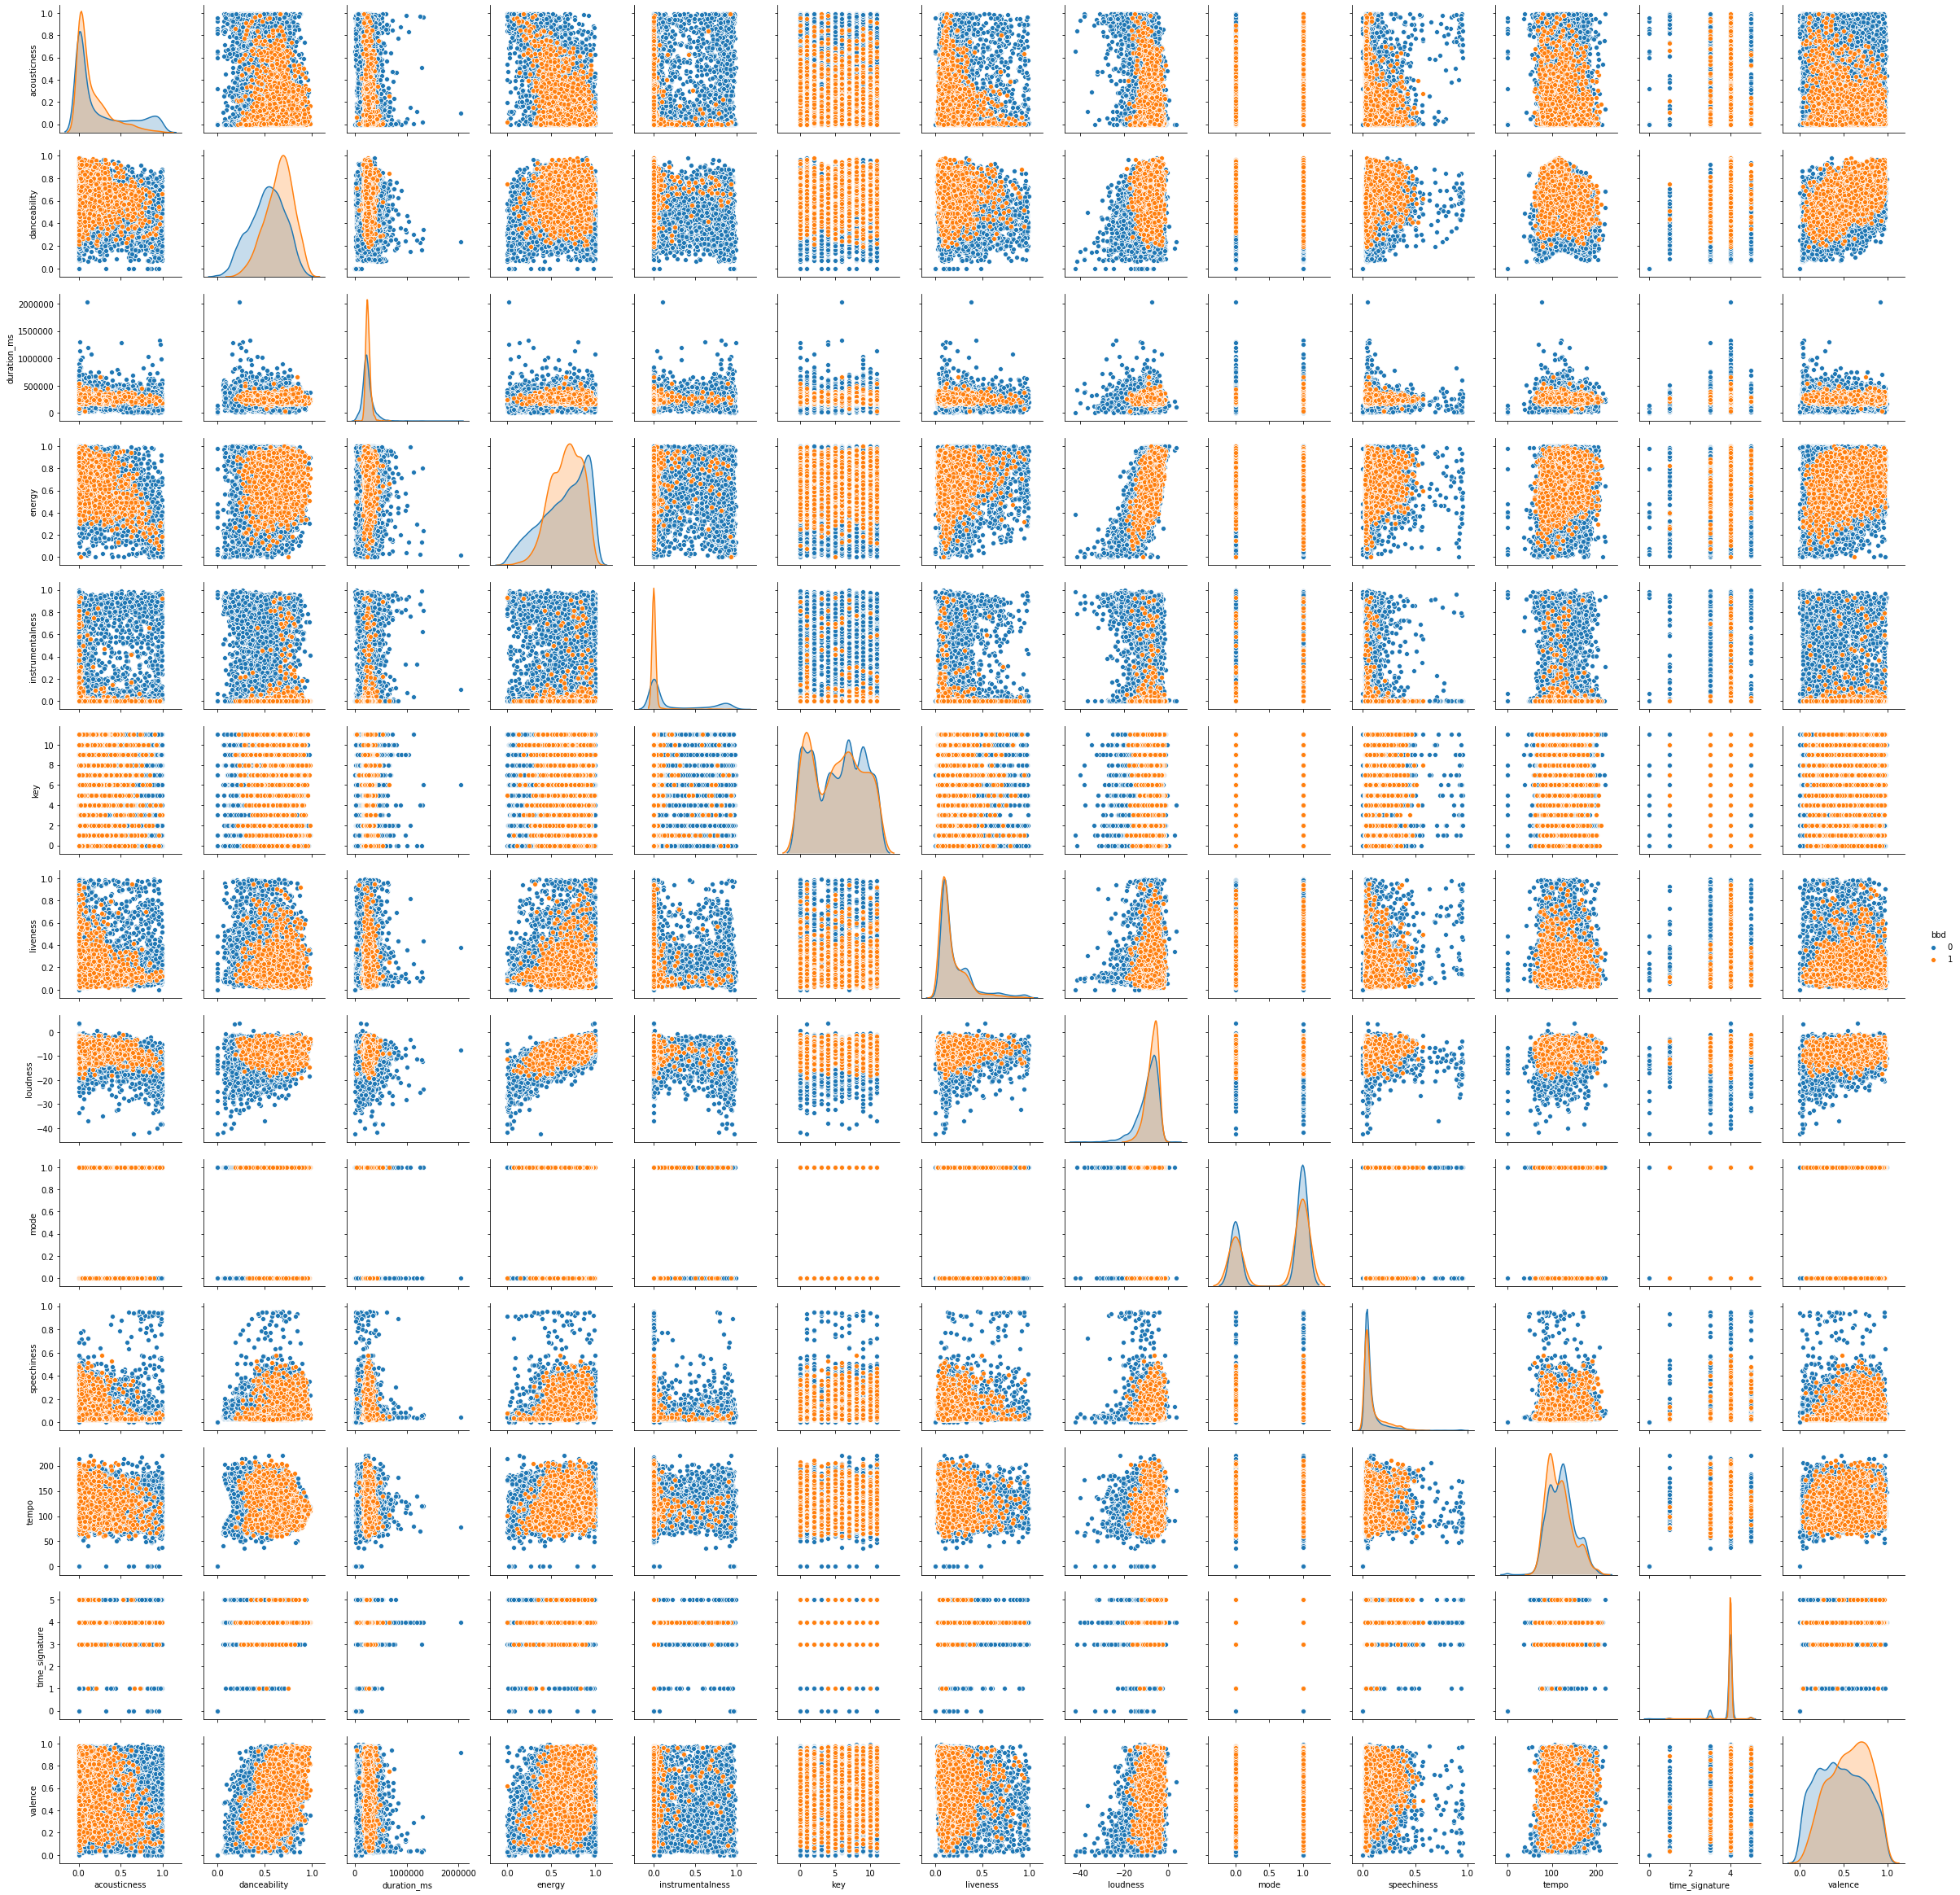

In [19]:
sb.pairplot(df_graph, hue = 'bbd', vars=df_graph.columns[:-1])

As you can see from above, it seems that there are no much correlated variables in this data. Just in case, I will check the correlation of each and then if correlation is higher that certain value(such as 0.8), I will eliminate it becuase I don't need similar variables which can be represented by only one variable.

In [20]:
corr_matrix = df.corr()

corr_matrix[corr_matrix == 1] = 0
corr_matrix.max()

acousticness        0.077780
bbd                 0.532540
danceability        0.516791
duration_ms         0.190945
energy              0.745580
ever_bbd            0.532540
instrumentalness    0.190945
liveness            0.178038
loudness            0.745580
mode                0.128359
speechiness         0.178038
tempo               0.201367
time_signature      0.195748
valence             0.516791
C                   0.128359
C#                  0.082611
D                   0.112904
D#                  0.077780
E                   0.014341
F                   0.048037
F#                  0.049219
G                   0.125729
G#                  0.052046
A                   0.028423
A#                  0.053403
B                   0.038013
dtype: float64

It seems like energy and loundness has the highest correlation, but it's under 0.8, so I will ignore it.

# 2. Devide the data into training and test data set.

### train_test_split

I will split the dataset into train data and test data. The proportion of train and test data is 75:25. Also, I use the "stratified sampling" to split the data with keeping the proportion of "df.bbd"(0 or 1). 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df, df.bbd, random_state=1, stratify=df.bbd) #random_state->assign random seed(if None, it's gonna be differemt values every time you run it.) stratify->designate what you gonna use for stratify samplijng.
X_train = X_train.drop("bbd", axis=1)
X_test = X_test.drop("bbd", axis=1)

In [22]:
# The proportion is approximately 7.5:2.5.
len(X_train)/len(df)

0.74994617868676

In [23]:
# The proportion of "bbd" is also same.
print(y_train.value_counts()[0]/y_train.value_counts()[1]) # train data
print(y_test.value_counts()[0]/y_test.value_counts()[1]) # test data

4.44296875
4.4402810304449645


# 3. Use some machine learning model to predict whether the songs are in top100 or not.

Now, it's time to apply some machine learning models. Before diving into that, I will create some functions to make the process more smooth. Then, because the dataset is imbalanced, I will try 2 methods each, SMOTE, SMOTEENN. In each method, I apply some machine learning models. The models are Logistic Regression, KNN, RandomForest, support vector machine and Neural Network.

### Function of RFE(Recursive Features Elimination)

I will look at the features whose performance are good or bad. 

In [24]:
def rfe(X, y, model):
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring="f1_macro") #model of RFECV
    rfecv.fit(X, y) #fit the model
    
    #plot the graph
    plt.figure(figsize=(16, 9))
    plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
    plt.show()
    
    #print the unnecessary features then remove
    print("removed features:", np.where(rfecv.support_ == False)[0])
    new_X_train = X.copy()
    new_X_train.drop(new_X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
    return new_X_train

The above shows logistic regression model and rfecv model. This rfecv model is constructed by searching the with what features the estimator performs well or not. rfecv has the proper number of features, which features have importance and so on.

### Function of Plotting

This function will plot the roc curve and calculate the auc.

In [25]:
def roc_auc_plot(y_test, y_prediction):
    # FPR, TPR, thresholds
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prediction)

    # AUC
    auc = metrics.auc(fpr, tpr)

    # plot the roc curve
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.grid(True)

### Function of confusion matrix and values

This function will give you the confusion matrix and other values such as precision, recall, F-1 score.

In [26]:
def cf_matrix(y_test, y_prediction):
    tn,fp,fn,tp = confusion_matrix(y_test, y_prediction).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    print("confsion matrix:")
    print(confusion_matrix(y_test, y_prediction))
    print("Precision:", precision)
    print("Recall(sensitivity):", recall)
    print("F-1 score:", f1)
    
    return precision, recall, f1

In [27]:
'''
A = Negative, B = Positive

          Predicted
          A    B
Actual A  TN   FP
       B  FN   TP
'''

'\nA = Negative, B = Positive\n\n          Predicted\n          A    B\nActual A  TN   FP\n       B  FN   TP\n'

### Function of Cross-validation 

Check if the model is working well or not by using cross-validation.

In [28]:
def cross_validation(X,y,pipeline):
    acc_scores = cross_val_score(pipeline, X, y, cv=5)  # cv refers to number of cross-validation cuts
    f1_scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro')

    print("accuracy", acc_scores.mean())
    print("f1_score" ,f1_scores.mean())
    print(f1_scores)
    
    return acc_scores.mean()

## __Oversampling by using SMOTE(Synthetic Minority Oversampling Technique)__

Then, I will apply SMOTE and make dataset balanced.

In [29]:
print(y_train.value_counts()[1]/y_train.value_counts().sum()) #The proportion of bbd==1 in the train set
print(y_test.value_counts()[1]/y_test.value_counts().sum()) #The proportion of bbd==1 in the test set

0.18372326682933832
0.18381403357727077


As you can tell from above, the data is imbalanced because of the minor class(bbd=1). Therefore, I will oversample by using SMOTE

In [30]:
os = SMOTE(random_state=1)

#columns = X_train.columns
os_X_train, os_y_train = os.fit_sample(X_train, y_train) #X_train should not include dependent variable when using this SMOTE algorithm.

print("length of os_X_rrain:", len(os_X_train))
print("length of os_y_train:", len(os_y_train))

print("The proportion of 0&1 in os_y_train:")
print(os_y_train.value_counts())

length of os_X_rrain: 11374
length of os_y_train: 11374
The proportion of 0&1 in os_y_train:
1.0    5687
0.0    5687
Name: bbd, dtype: int64


What I did in above is that I oversampled the minor data(bbd=1). The length of X_train was 6967, but after applying SMOTE, the length increases to 11374, and The proportion of bbd==0,1 is 5:5. I get perfect balaned data.

By using these 2 datasets(os_X_train, os_y_train), I will try models.

### __Logistic Regression__

First, I will apply Recursive Feature Elimination. 

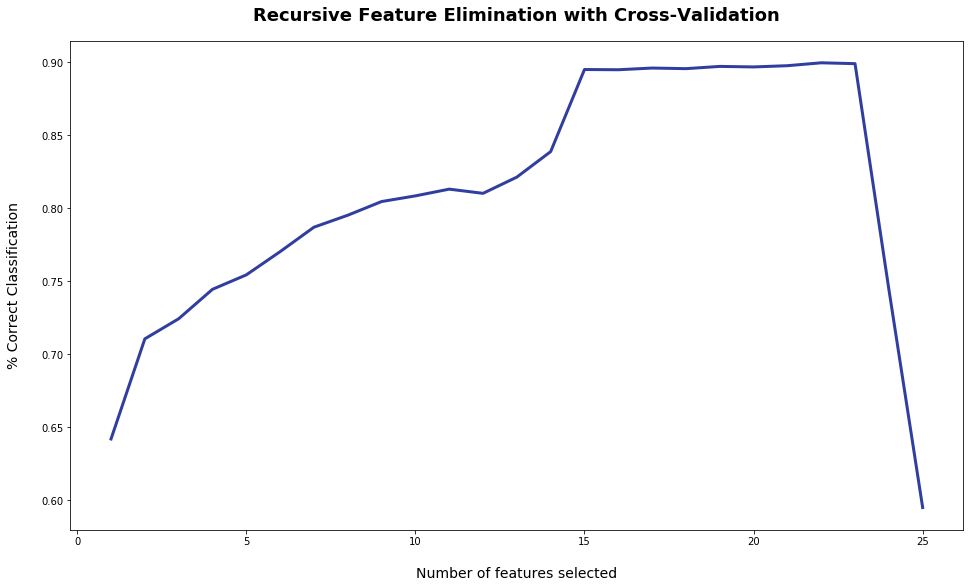

removed features: [ 2  8 10]


In [31]:
log_X_train = rfe(os_X_train, os_y_train, LogisticRegression())

"log_X_train" is the dataset after applying RFE. 

Then, make the pipeline to do Normalization and Logistic Regression.

In [32]:
acc_lis=[] #the accuracy list

log_pipeline = make_pipeline(StandardScaler(), LogisticRegression())
acc_lis.append(cross_validation(log_X_train,os_y_train,log_pipeline))

accuracy 0.8884354625146182
f1_score 0.8819366645322575
[0.64364194 0.92386655 0.95472402 0.93406562 0.9533852 ]


In cross_validation, the score is pretty good. Then, I will fit the model and try to predict the test value.

In [33]:
columns = log_X_train.columns
log_X_test = X_test[columns]

log_pipeline.fit(log_X_train, os_y_train)
log_y_prediction = log_pipeline.predict(log_X_test)

In [34]:
pre_lis = [] #the precision list
re_lis = [] #the recall list
f1_lis = [] #the f1 list

pre, re, f1 = cf_matrix(y_test, log_y_prediction)

pre_lis.append(pre)
re_lis.append(re)
f1_lis.append(f1)

confsion matrix:
[[1771  125]
 [ 201  226]]
Precision: 0.6438746438746439
Recall(sensitivity): 0.5292740046838408
F-1 score: 0.5809768637532134


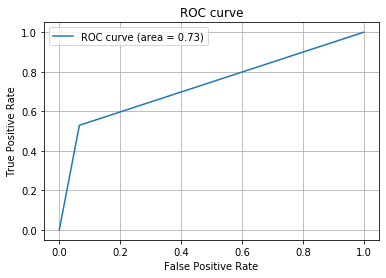

In [35]:
roc_auc_plot(y_test, log_y_prediction)

## __K-Nearest Neighbors__

Before using this model, I will grid search to find appropriate parameter.

#### Grid Search

In [36]:
knn = KNeighborsClassifier()

params_knn = {"n_neighbors": np.arange(1,25)} #create a dic for testing what n_neighbors value is the best
knn_gs = GridSearchCV(knn, params_knn, cv=5) #use gridseardh to test all values for n_nighbors
knn_gs.fit(os_X_train, os_y_train) #fit model

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [37]:
#save best model
knn_best = knn_gs.best_estimator_
print(knn_best) #best n_neighbors = 5

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


From above, I save the best model. Then I will use this one.

In [38]:
knn_pipeline = make_pipeline(StandardScaler(), knn_best)
acc_lis.append(cross_validation(os_X_train,os_y_train,knn_pipeline))

accuracy 0.8814020315656199
f1_score 0.8762452592640955
[0.65097761 0.91162861 0.93833017 0.93223006 0.94805984]


In [39]:
knn_pipeline.fit(os_X_train, os_y_train)
knn_y_prediction = knn_pipeline.predict(X_test)

In [40]:
pre, re, f1 = cf_matrix(y_test, knn_y_prediction)
pre_lis.append(pre)
re_lis.append(re)
f1_lis.append(f1)

confsion matrix:
[[1706  190]
 [ 198  229]]
Precision: 0.5465393794749404
Recall(sensitivity): 0.5362997658079626
F-1 score: 0.541371158392435


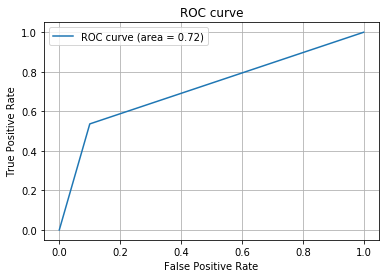

In [41]:
roc_auc_plot(y_test, knn_y_prediction)

## __Random Forest__

The below takes while to execute(around 3-5minutes)

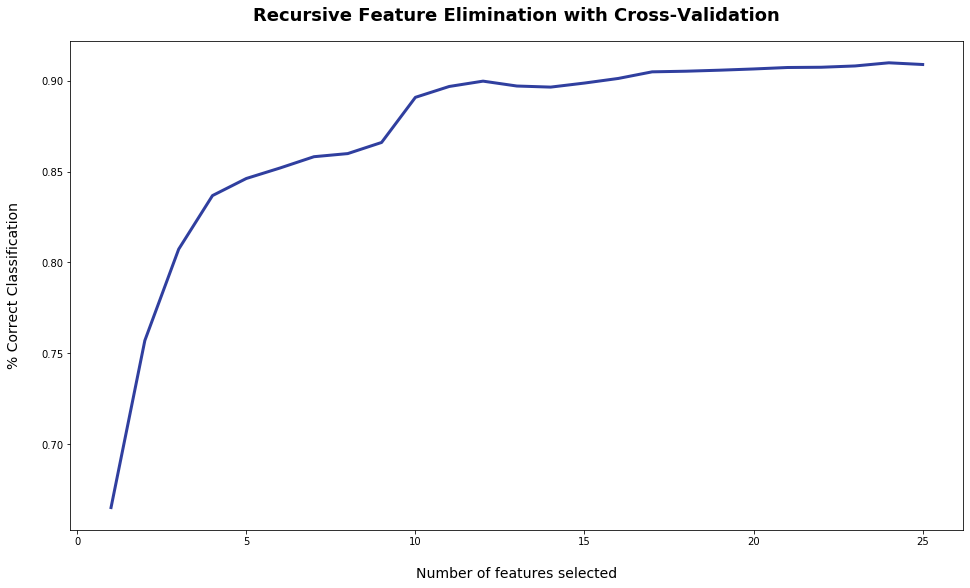

removed features: [16]


In [42]:
#make the dataframe only for random forest.
rf_X_train = rfe(os_X_train, os_y_train, RandomForestClassifier(n_estimators=100, bootstrap=True, max_features="sqrt"))

In [43]:
rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, bootstrap=True, max_features="sqrt"))
acc_lis.append(cross_validation(rf_X_train,os_y_train,rf_pipeline))

accuracy 0.88614889771618
f1_score 0.8861313312762322
[0.67781696 0.92922727 0.94459371 0.92873998 0.95027874]


In [44]:
columns = rf_X_train.columns
rf_X_test = X_test[columns]

rf_pipeline.fit(rf_X_train, os_y_train)
rf_y_prediction = rf_pipeline.predict(rf_X_test)

In [45]:
pre,re,f1 = cf_matrix(y_test, rf_y_prediction)
pre_lis.append(pre)
re_lis.append(re)
f1_lis.append(f1)

confsion matrix:
[[1746  150]
 [ 168  259]]
Precision: 0.6332518337408313
Recall(sensitivity): 0.6065573770491803
F-1 score: 0.6196172248803828


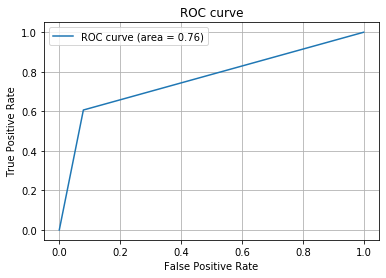

In [46]:
roc_auc_plot(y_test, rf_y_prediction)

## __SVM(Support Vector Machine)__

In [47]:
svm_pipeline = make_pipeline(StandardScaler(), SVC())
acc_lis.append(cross_validation(os_X_train,os_y_train,svm_pipeline))

accuracy 0.8858864372215296
f1_score 0.8757806385418607
[0.58606232 0.9269261  0.96307674 0.94461529 0.95822274]


In [48]:
svm_pipeline.fit(os_X_train, os_y_train)
svm_y_prediction = svm_pipeline.predict(X_test)

In [49]:
pre,re,f1 = cf_matrix(y_test, svm_y_prediction)
pre_lis.append(pre)
re_lis.append(re)
f1_lis.append(f1)

confsion matrix:
[[1800   96]
 [ 224  203]]
Precision: 0.6789297658862876
Recall(sensitivity): 0.47540983606557374
F-1 score: 0.559228650137741


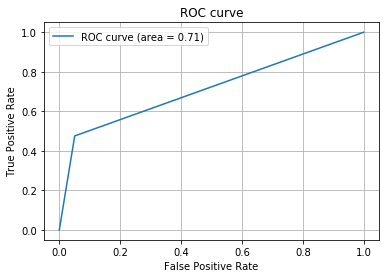

In [50]:
roc_auc_plot(y_test, svm_y_prediction)

## __Neural Network__

In [51]:
nn_pipeline = make_pipeline(StandardScaler(), MLPClassifier(activation="logistic",solver="sgd",random_state=0,max_iter=10000))
acc_lis.append(cross_validation(os_X_train,os_y_train,nn_pipeline))

accuracy 0.8879957860960499
f1_score 0.8820394008026774
[0.65337044 0.92170195 0.9507623  0.93229816 0.95206416]


In [52]:
nn_pipeline.fit(os_X_train, os_y_train)
nn_y_prediction = nn_pipeline.predict(X_test)

In [53]:
pre,re,f1 = cf_matrix(y_test, nn_y_prediction)
pre_lis.append(pre)
re_lis.append(re)
f1_lis.append(f1)

confsion matrix:
[[1761  135]
 [ 196  231]]
Precision: 0.6311475409836066
Recall(sensitivity): 0.5409836065573771
F-1 score: 0.5825977301387137


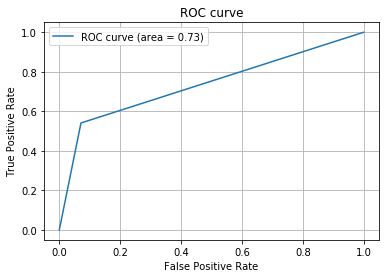

In [54]:
roc_auc_plot(y_test, nn_y_prediction)

### __Result of SMOTE__

In [55]:
print("Logistic Regression, ", "KNN, ", "Random Forest, ", "SVM, ", "Neutral Network")
print("accuracy(cross-validation)):", acc_lis)
print("precision:", pre_lis)
print("recall:", re_lis)
print("f1 score:", f1_lis)

Logistic Regression,  KNN,  Random Forest,  SVM,  Neutral Network
accuracy(cross-validation)): [0.8884354625146182, 0.8814020315656199, 0.88614889771618, 0.8858864372215296, 0.8879957860960499]
precision: [0.6438746438746439, 0.5465393794749404, 0.6332518337408313, 0.6789297658862876, 0.6311475409836066]
recall: [0.5292740046838408, 0.5362997658079626, 0.6065573770491803, 0.47540983606557374, 0.5409836065573771]
f1 score: [0.5809768637532134, 0.541371158392435, 0.6196172248803828, 0.559228650137741, 0.5825977301387137]


## __Oversampling(SMOTE) and Undersampling(SMOTEENN)__

So far, I cannot get the good value on the test data, so I will try SMOTEENN method.

In this method, I will do oversampling and undersampling concurrently, which means oversample minor class, undersanple major class. As a method, I will apply SMOTEENN.

In [56]:
osus = SMOTEENN(sampling_strategy="minority",random_state=1, smote=SMOTE(random_state=1))
osus_X_train, osus_y_train = osus.fit_sample(X_train, y_train)

print("length of osus_X_rrain:", len(osus_X_train))
print("length of osus_y_train:", len(osus_y_train))

print("The proportion of 0&1 in osus_y_train:")
print(osus_y_train.value_counts())

length of osus_X_rrain: 5285
length of osus_y_train: 5285
The proportion of 0&1 in osus_y_train:
1.0    2836
0.0    2449
Name: bbd, dtype: int64


I will use osus_X_train, osus_y_train. Basically, I will just go over the process that I did in SMOTE.

In [57]:
os_X_train = osus_X_train.copy()
os_y_train = osus_y_train.copy()

### __Logistic Regression__

First, I will apply Recursive Feature Elimination. 

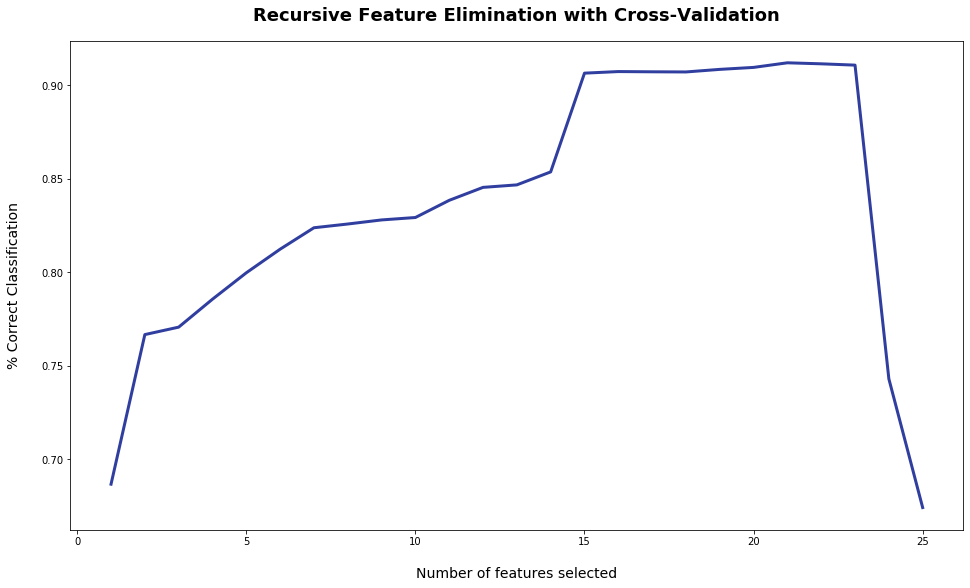

removed features: [ 2  7  8 10]


In [58]:
log_X_train = rfe(os_X_train, os_y_train, LogisticRegression())

"log_X_train" is the dataset after applying RFE. 

Then, make the pipeline to do Normalization and Logistic Regression.

In [59]:
acc2_lis = []

log_pipeline = make_pipeline(StandardScaler(), LogisticRegression())
acc2_lis.append(cross_validation(log_X_train,os_y_train,log_pipeline))

accuracy 0.8970671712393565
f1_score 0.8940837930291773
[0.68849201 0.93719028 0.95430671 0.94386006 0.9465699 ]


In [60]:
columns = log_X_train.columns
log_X_test = X_test[columns]

log_pipeline.fit(log_X_train, os_y_train)
log_y_prediction = log_pipeline.predict(log_X_test)

In [61]:
pre2_lis = []
re2_lis = []
f12_lis = []

pre2, re2, f12 = cf_matrix(y_test, log_y_prediction)
pre2_lis.append(pre2)
re2_lis.append(re2)
f12_lis.append(f12)

confsion matrix:
[[1716  180]
 [ 175  252]]
Precision: 0.5833333333333334
Recall(sensitivity): 0.5901639344262295
F-1 score: 0.5867287543655414


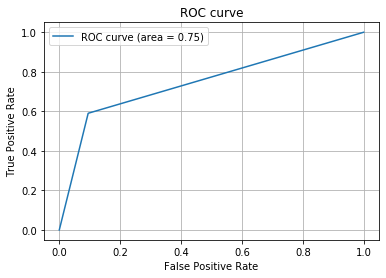

In [62]:
roc_auc_plot(y_test, log_y_prediction)

## __K-Nearest Neighbors__

Before using this model, I will grid search to find appropriate parameter.

#### Grid Search

In [63]:
knn = KNeighborsClassifier()

params_knn = {"n_neighbors": np.arange(1,25)} #create a dic for testing what n_neighbors value is the best
knn_gs = GridSearchCV(knn, params_knn, cv=5) #use gridseardh to test all values for n_nighbors
knn_gs.fit(os_X_train, os_y_train) #fit model

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [64]:
#save best model
knn_best = knn_gs.best_estimator_
print(knn_best) #best n_neighbors = 1

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


From above, I save the best model. Then I will use this one.

In [65]:
knn_pipeline = make_pipeline(StandardScaler(), knn_best)
acc2_lis.append(cross_validation(os_X_train,os_y_train,knn_pipeline))

accuracy 0.8894985808893094
f1_score 0.8874757800867419
[0.72230493 0.91814779 0.94329734 0.92683309 0.92679575]


In [66]:
knn_pipeline.fit(os_X_train, os_y_train)
knn_y_prediction = knn_pipeline.predict(X_test)

In [67]:
pre2, re2, f12 = cf_matrix(y_test, knn_y_prediction)
pre2_lis.append(pre2)
re2_lis.append(re2)
f12_lis.append(f12)

confsion matrix:
[[1564  332]
 [ 153  274]]
Precision: 0.4521452145214521
Recall(sensitivity): 0.6416861826697893
F-1 score: 0.5304937076476283


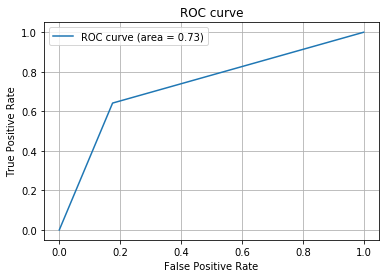

In [68]:
roc_auc_plot(y_test, knn_y_prediction)

## __Random Forest__

The below takes while to execute(around 3-5minutes)

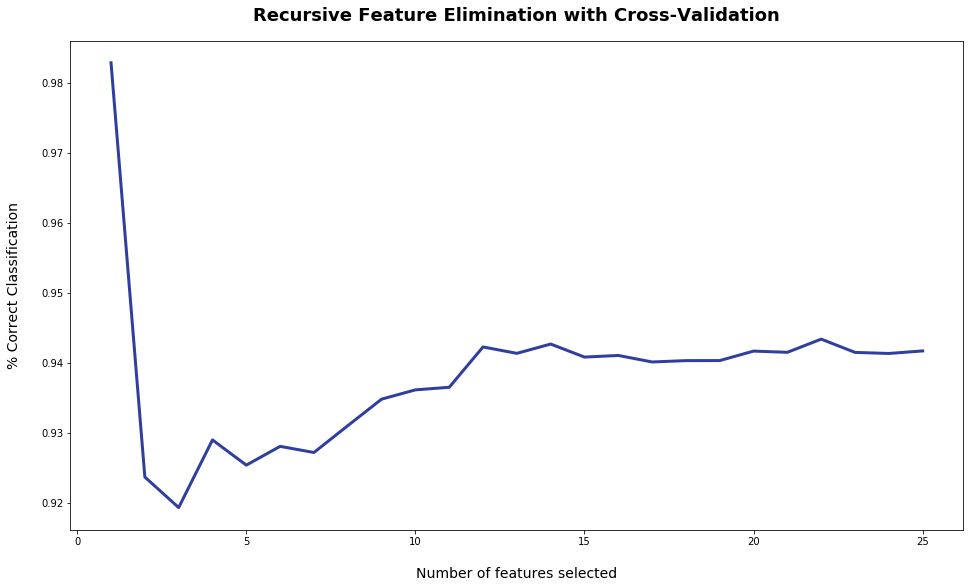

removed features: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [69]:
#make the dataframe only for random forest.
rf_X_train = rfe(os_X_train, os_y_train, RandomForestClassifier(n_estimators=100, bootstrap=True, max_features="sqrt"))

In [70]:
rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, bootstrap=True, max_features="sqrt"))
acc2_lis.append(cross_validation(rf_X_train,os_y_train,rf_pipeline))

accuracy 0.9799432355723747
f1_score 0.9803788953187755
[0.98191035 0.9847689  0.97141513 0.9857187  0.97808139]


In [71]:
columns = rf_X_train.columns
rf_X_test = X_test[columns]

rf_pipeline.fit(rf_X_train, os_y_train)
rf_y_prediction = rf_pipeline.predict(rf_X_test)

In [72]:
pre2, re2, f12 = cf_matrix(y_test, rf_y_prediction)
pre2_lis.append(pre2)
re2_lis.append(re2)
f12_lis.append(f12)

confsion matrix:
[[1122  774]
 [ 175  252]]
Precision: 0.24561403508771928
Recall(sensitivity): 0.5901639344262295
F-1 score: 0.3468685478320716


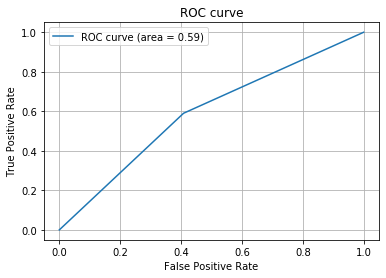

In [73]:
roc_auc_plot(y_test, rf_y_prediction)

## __SVM(Support Vector Machine)__

In [74]:
svm_pipeline = make_pipeline(StandardScaler(), SVC())
acc2_lis.append(cross_validation(os_X_train,os_y_train,svm_pipeline))

accuracy 0.9033112582781457
f1_score 0.8987239566534093
[0.64215791 0.95627203 0.96759329 0.96094024 0.9666563 ]


In [75]:
svm_pipeline.fit(os_X_train, os_y_train)
svm_y_prediction = svm_pipeline.predict(X_test)

In [76]:
pre2, re2, f12 = cf_matrix(y_test, svm_y_prediction)
pre2_lis.append(pre2)
re2_lis.append(re2)
f12_lis.append(f12)

confsion matrix:
[[1734  162]
 [ 186  241]]
Precision: 0.598014888337469
Recall(sensitivity): 0.5644028103044496
F-1 score: 0.5807228915662651


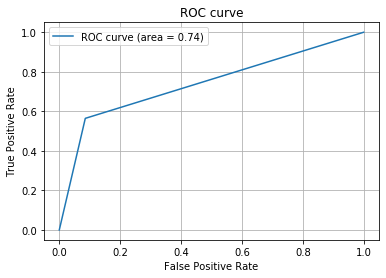

In [77]:
roc_auc_plot(y_test, svm_y_prediction)

## __Neural Network__

In [78]:
nn_pipeline = make_pipeline(StandardScaler(), MLPClassifier(activation="logistic",solver="sgd",random_state=0,max_iter=10000))
acc2_lis.append(cross_validation(os_X_train,os_y_train,nn_pipeline))

accuracy 0.9027436140018921
f1_score 0.900433107288074
[0.71380513 0.93805611 0.95714297 0.94182944 0.95133188]


In [79]:
nn_pipeline.fit(os_X_train, os_y_train)
nn_y_prediction = nn_pipeline.predict(X_test)

In [80]:
pre2, re2, f12 = cf_matrix(y_test, nn_y_prediction)
pre2_lis.append(pre2)
re2_lis.append(re2)
f12_lis.append(f12)

confsion matrix:
[[1688  208]
 [ 160  267]]
Precision: 0.5621052631578948
Recall(sensitivity): 0.6252927400468384
F-1 score: 0.5920177383592018


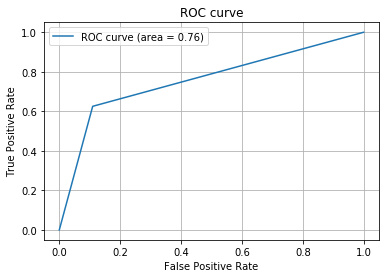

In [81]:
roc_auc_plot(y_test, nn_y_prediction)

### __Result of SMOTEENN__

In [82]:
print("Logistic Regression, ", "KNN, ", "Random Forest, ", "SVM, ", "Neutral Network")
print("accuracy(cross-validation)):", acc2_lis)
print("precision:", pre2_lis)
print("recall:", re2_lis)
print("f1 score:", f12_lis)

Logistic Regression,  KNN,  Random Forest,  SVM,  Neutral Network
accuracy(cross-validation)): [0.8970671712393565, 0.8894985808893094, 0.9799432355723747, 0.9033112582781457, 0.9027436140018921]
precision: [0.5833333333333334, 0.4521452145214521, 0.24561403508771928, 0.598014888337469, 0.5621052631578948]
recall: [0.5901639344262295, 0.6416861826697893, 0.5901639344262295, 0.5644028103044496, 0.6252927400468384]
f1 score: [0.5867287543655414, 0.5304937076476283, 0.3468685478320716, 0.5807228915662651, 0.5920177383592018]


## __Results__

Compare it

([<matplotlib.axis.XTick at 0x7f3fe6c4e518>,
 <a list of 5 Text xticklabel objects>)

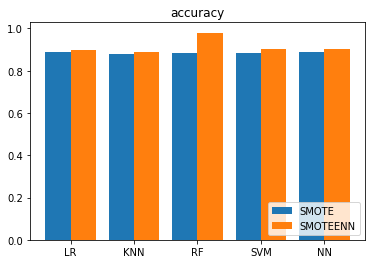

In [92]:
x = ["LR", "KNN", "RF", "SVM", "NN"]

ax = plt.subplot(111)
X = np.arange(len(f12_lis))

ax.bar(X,acc_lis, width=0.4,label="SMOTE",align="center")
ax.bar(0.4+X,acc2_lis, width=0.4,label="SMOTEENN",align="center")

plt.legend(loc="lower right")
plt.title("accuracy")
plt.xticks(X+0.2,x)

Accuracy is high enough, but this accuracy is made by referrin the over sampled or under sampled data.Therefore, not reliable value.

([<matplotlib.axis.XTick at 0x7f3fe6e50a90>,
 <a list of 5 Text xticklabel objects>)

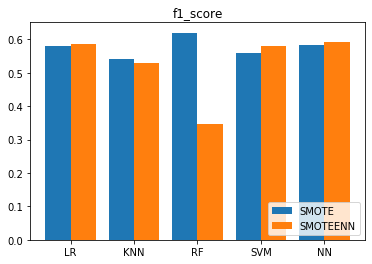

In [83]:
x = ["LR", "KNN", "RF", "SVM", "NN"]

ax = plt.subplot(111)
X = np.arange(len(f12_lis))

ax.bar(X,f1_lis, width=0.4,label="SMOTE",align="center")
ax.bar(0.4+X,f12_lis, width=0.4,label="SMOTEENN",align="center")

plt.legend(loc="lower right")
plt.title("f1_score")
plt.xticks(X+0.2,x)

f1_score in SMOTEENN performs slightly higher than SMOTE. However, in Random Forest SMOTE works pretty better than SMOTEENN. Therefore, there not much difference between using SMOTE or SMOTEENN in this case.

([<matplotlib.axis.XTick at 0x7f3fe6de8f28>,
 <a list of 5 Text xticklabel objects>)

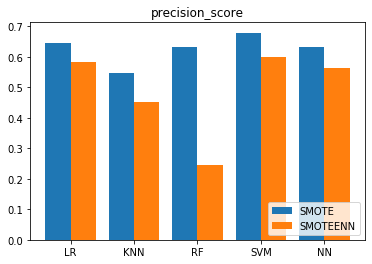

In [84]:
x = ["LR", "KNN", "RF", "SVM", "NN"]

ax = plt.subplot(111)
X = np.arange(len(f12_lis))

ax.bar(X,pre_lis, width=0.4,label="SMOTE",align="center")
ax.bar(0.4+X,pre2_lis, width=0.4,label="SMOTEENN",align="center")

plt.legend(loc="lower right")
plt.title("precision_score")
plt.xticks(X+0.2,x)

In precision score, the performance in SMOTE is better than SMOTEENN as well. Especially Random Forest, SMOTE works pretty well.

([<matplotlib.axis.XTick at 0x7f3fe6d5b588>,
 <a list of 5 Text xticklabel objects>)

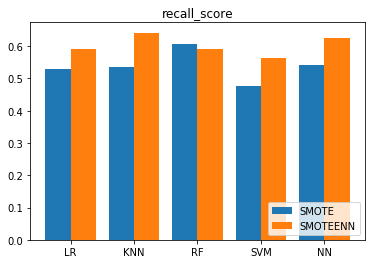

In [85]:
x = ["LR", "KNN", "RF", "SVM", "NN"]

ax = plt.subplot(111)
X = np.arange(len(f12_lis))

ax.bar(X,re_lis, width=0.4,label="SMOTE",align="center")
ax.bar(0.4+X,re2_lis, width=0.4,label="SMOTEENN",align="center")

plt.legend(loc="lower right")
plt.title("recall_score")
plt.xticks(X+0.2,x)

In recall score, the SMOTEENN performs better than that in SMOTE. This means actual Positive is caught better at SMOTEENN than SMOTE.

# __Conclusion__

In this phase, I applied some sampling method, grid search, cross-validation, machine learning algorithm, RFE and so on. The biggest method that influence in good way is Oversampling(SMOTE) and undersampling. SMOTE works for increasing the number of minor class because the dataset was prettu imbalanced before applying. Before applying those, the f-1 score was much lower such as 0.3 and so on. But by applying those, there are some better error rate that I could get(around0.6), not desiable though. Also, I applied SMOTEENN which oversample the minor class and undersample the major class concurrently, but it does not show the results as I expected. In bothe SMOTE and SMOTEENN, I applied RFE(Recursive Feature Elimination) which works pretty good as well because I can get the features which perform the best. RFE are applied only in Logistic Regression and Random Forest, but it improves error. Also, I applied grid search which can be done with cross-validation method to find the desiable parameter in KNN. However, even I got desiable parameter by that, the performance did not improve not much. Also, adding new features "ever_bbd"(1 if the artist made the song in top100 before, 0 if the artist did not make it) improves the performance as well. In total, it seems like Random Forest perfoms the best out of all the 5 models when using SMOTE. In contrast, the KNN performs worst out of all the models.　In conclusion, I can get around 0.6 f1_score in general. This is not the perfect score, but it does improve exceedingly.